## Text Similarity using Word Embeddings

In this notebook we're going to play around with pre build word embeddings and do some fun calculations:

In [4]:
%matplotlib inline

import os
from keras.utils import get_file
import gensim
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
figsize(10, 10)

from sklearn.manifold import TSNE
import json
from collections import Counter
from itertools import chain

## 3.1　使用预训练的词嵌入发现词的相似性

使用Google新闻这个模型。它有300万个词嵌入，并用大约1000亿个摘自Google新闻档案的单词训练过。下载它需要一段时间，所以我们将在本地缓存这个文件：

In [6]:
MODEL = 'GoogleNews-vectors-negative300.bin'
path = get_file(MODEL + '.gz', 'https://s3.amazonaws.com/dl4j-distribution/%s.gz' % MODEL)
if not os.path.isdir('generated'):
    os.mkdir('generated')

unzipped = os.path.join('generated', MODEL)
if not os.path.isfile(unzipped):
    with open(unzipped, 'wb') as fout:
        zcat = subprocess.Popen(['zcat'],
                          stdin=open(path),
                          stdout=fout
                         )
        zcat.wait()

1647050752/1647046227 [==============================] - 262s 0us/step


In [8]:
model = gensim.models.KeyedVectors.load_word2vec_format(unzipped, binary=True)

In [11]:
model.most_similar(positive=['good'])

[('great', 0.7291510105133057),
 ('bad', 0.7190051078796387),
 ('terrific', 0.6889115571975708),
 ('decent', 0.6837348341941833),
 ('nice', 0.6836092472076416),
 ('excellent', 0.644292950630188),
 ('fantastic', 0.6407778263092041),
 ('better', 0.6120728850364685),
 ('solid', 0.5806034803390503),
 ('lousy', 0.576420247554779)]

## 3.2　Word2vec数学特性

现在我们可以将此应用到任意的词语之中，例如，为了找到与“king”和“son”之间关系相似的与“daughter”对应的单词：

In [17]:
def A_is_to_B_as_C_is_to(a, b, c, topn=1):
    a, b, c = map(lambda x:x if type(x) == list else [x], (a, b, c))
    res = model.most_similar(positive=b + c, negative=a, topn=topn)
    if len(res):
        if topn == 1:
            return res[0][0]
        return [x[0] for x in res]
    return None

我们也可以使用这个方法查找一些选定国家的首都：

In [18]:
for country in 'Italy', 'France', 'India', 'China':
    print('%s is the capital of %s' % 
          (A_is_to_B_as_C_is_to('Germany', 'Berlin', country), country))

Rome is the capital of Italy
Paris is the capital of France
Delhi is the capital of India
Beijing is the capital of China


或者是查找公司的主要产品（注意#占位符代表词嵌入中的任意数值）：

In [19]:
for company in 'Google', 'IBM', 'Boeing', 'Microsoft', 'Samsung':
    products = A_is_to_B_as_C_is_to(['Starbucks', 'Apple'], ['Starbucks_coffee', 'iPhone'], company, topn=3)
    print('%s -> %s' %(company, ', '.join(products)))

Google -> personalized_homepage, app, Gmail
IBM -> DB2, WebSphere_Portal, Tamino_XML_Server
Boeing -> Dreamliner, airframe, aircraft
Microsoft -> Windows_Mobile, SyncMate, Windows
Samsung -> MM_A###, handset, Samsung_SCH_B###


## 3.3　可视化词嵌入

浏览一个300维的空间非常困难，但是幸运的是我们可以使用称为t分布随机邻域嵌入（t-SNE）的算法把更高维度的空间折叠成更易理解的低维度空间，比如两个维度。
假设我们想看看三组词是如何划分的。我们将选择国家、体育和饮料：

In [28]:
beverages = ['espresso', 'beer', 'vodka', 'wine', 'cola', 'tea']
countries = ['Italy', 'Germany', 'Russia', 'France', 'USA', 'India']
sports = ['soccer', 'handball', 'hockey', 'cycling', 'basketball', 'cricket']

items = beverages + countries + sports
len(items)

18

In [29]:
item_vectors = [(item, model[item]) 
                    for item in items
                    if item in model]
len(item_vectors)

18

我们现在能够在300维空间中使用t-SNE算法寻找类簇：

In [38]:
vectors = np.asarray([x[1] for x in item_vectors])
lengths = np.linalg.norm(vectors, axis=1)
norm_vectors = (vectors.T / lengths).T

tsne = TSNE(n_components=2, perplexity=10, verbose=2).fit_transform(norm_vectors)

[t-SNE] Computing 17 nearest neighbors...
[t-SNE] Indexed 18 samples in 0.000s...
[t-SNE] Computed neighbors for 18 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 18 / 18
[t-SNE] Mean sigma: 0.581543
[t-SNE] Computed conditional probabilities in 0.001s
[t-SNE] Iteration 50: error = 55.3959885, gradient norm = 0.2049821 (50 iterations in 0.026s)
[t-SNE] Iteration 100: error = 51.1213531, gradient norm = 0.1761280 (50 iterations in 0.014s)
[t-SNE] Iteration 150: error = 72.4438629, gradient norm = 0.7622188 (50 iterations in 0.012s)
[t-SNE] Iteration 200: error = 53.8321304, gradient norm = 0.0466580 (50 iterations in 0.011s)
[t-SNE] Iteration 250: error = 52.1886864, gradient norm = 0.0386519 (50 iterations in 0.010s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.188686
[t-SNE] Iteration 300: error = 0.8231727, gradient norm = 0.0013760 (50 iterations in 0.011s)
[t-SNE] Iteration 350: error = 0.5230851, gradient norm = 0.0004190 (50 i

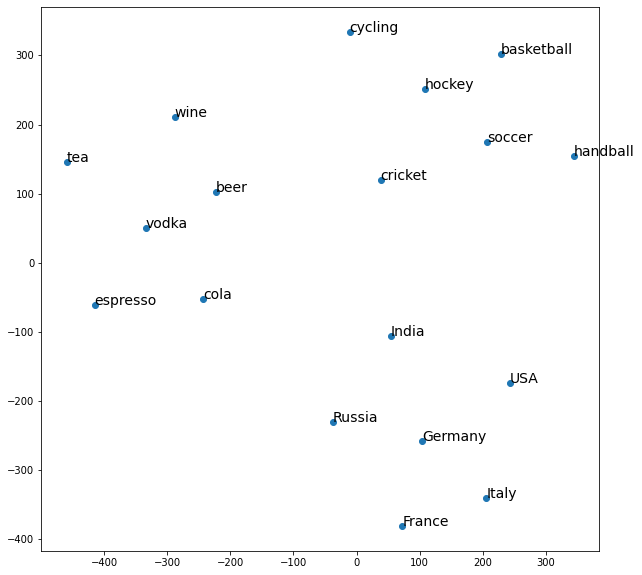

In [40]:
x=tsne[:,0]
y=tsne[:,1]

fig, ax = plt.subplots()
ax.scatter(x, y)

for item, x1, y1 in zip(item_vectors, x, y):
    ax.annotate(item[0], (x1, y1), size=14)

plt.show()

In [41]:
tsne

array([[-414.85898 ,  -60.812557],
       [-222.73367 ,  102.36681 ],
       [-333.38025 ,   50.311813],
       [-287.83197 ,  210.40659 ],
       [-243.00174 ,  -51.66716 ],
       [-458.89084 ,  145.70288 ],
       [ 205.47345 , -340.26892 ],
       [ 104.36076 , -258.4563  ],
       [ -37.83705 , -230.32527 ],
       [  72.78222 , -380.85794 ],
       [ 242.95996 , -174.01326 ],
       [  54.087368, -105.82611 ],
       [ 207.35507 ,  174.1055  ],
       [ 344.60013 ,  153.80902 ],
       [ 108.33683 ,  250.74756 ],
       [ -11.062773,  334.01358 ],
       [ 228.3243  ,  302.08218 ],
       [  38.228645,  120.15673 ]], dtype=float32)